# Modelling EM-APEX response to sinsoidal velocity at surface wave frequencies

This notebook shows the response of and EM-APEX float to a sinusoidaly varing current profile.

First we calculate the horizontal velocity of the float over time assuming the acceleration of the float 

$a_f = \frac{(C_{d}*A*\rho)}{M_{f}} * (u_w - u_f) * |u_w - u_f|$

Where here $u_w$ is the velocity of the float, and $u_w$ is the velocity of the water. $C_d$ is the drag coefficient, $A$ the area of the float, $\rho$ the density of water, and $M_f$ the mass of the float. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [3]:
#define coefficents
Cd = 1
Mf = 28 #kg. Value from Sanford 2007
A=.165*1.27 #(float area?) # Diameter and Height values from Sanford 2007
omega = 2*np.pi*0.08 #Go w/ a 12.5s swell for a sample
#amplitude of wave velocity
a = 1
#Water density
rho = 1000

In [4]:
#Function that returns velcotiy time series of the float assuming a quadratic drag force and x-velocity time series u
def get_u_float(u, tarr, Cd=1):
    a_arr = []
    u_float = 0
    u_float_saver = []
    #u_saver = []
    dt = tarr[2]-tarr[1]
    for u_t in u:
        #u = a * np.cos(omega*t)
        a_iter = (Cd*A*rho/Mf) * (u_t-u_float) * np.abs(u_t-u_float)
        a_arr = a_arr + [a_iter]
        u_float = u_float + a_iter*dt
        u_float_saver = u_float_saver + [u_float]
        #u_saver = u_saver +  [u]

    return(u_float_saver, a_arr)

## Plot a sample case of a single wave frequency

In [5]:
#build a sinusoidal wave velocity time series, and get the resulting float velocities
tarr = np.linspace(0, 50, 10000)
u = a * np.sin(omega*tarr)
u_float_saver, a_arr=get_u_float(u, tarr)

Text(0.5, 1.0, 'Surface Wave velocity and forced float velocity')

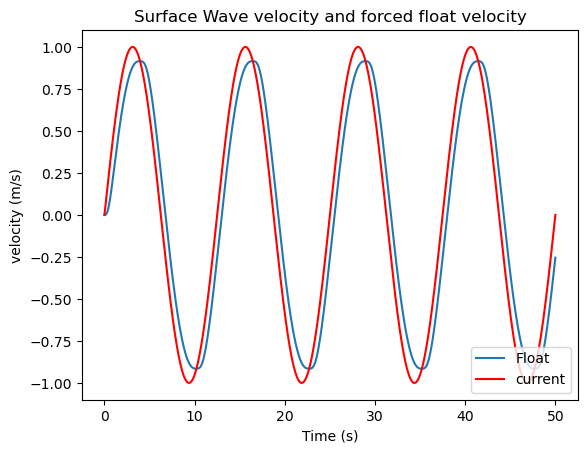

In [6]:
#Plot wave-current and resulting float velocities.
fig, ax1 = plt.subplots()

ax1.plot(np.linspace(0, 50, 10000), u_float_saver, label='Float')
ax1.plot(np.linspace(0, 50, 10000), u, color='red', label='current')
#plt.plot(a*np.cos(omega*np.linspace(0, 50, 1000)))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("velocity (m/s)")
ax1.legend(loc='lower right')
plt.title("Surface Wave velocity and forced float velocity")

So we can see based on this exampe that there's some slightly smaller max-velocity that the float reaches than the current reaches, as well as a small time-offset between the float's max velocity and the current's. Note that a 1m/s current amplitude at this frequency (0.08Hz) is equivalent to about a 2m wave, since the amplitude of the current velocity = $a_{\eta}*\omega$ where $a_{\eta}$ is the amplitude of the surface elevation of the surface wave.

## So, what's the impact of different frequencies?

Now we iterate over a range of surface wave frequencies, as well as a range of surface wave velocity amplitudes, and see what the impact is on the maximum magnitude of the float velocity.

In [26]:
#Vary omega and see what the difference in max response is
Cd = 1
Mf = 28 #kg
A=.165*1.27 #(float area?)
f = np.linspace(0.03, 0.3, 25)
omega = 2*np.pi*f #Go w/ a 10s wave
a_ar = np.arange(1, 6)
#eta_ar = np.arange(1, 6)
#a_ar = np.append(a_ar)
rho = 1000
diff_mat = np.zeros((len(a_ar), len(omega)))
for a_ind in range(len(a_ar)):
    a = a_ar[a_ind]
    diff_store = []
    tdiff_store = []
    max_u_store = []
    for o in omega:
        tarr = np.linspace(0, 25, 5000)
        u = a * o * np.cos(o*tarr)
        u_float_saver, a_arr=get_u_float(u, tarr)
        delta=u[2000:]-u_float_saver[2000:]
        ind = np.where(np.abs(delta)<0.01)[0][0]
        max_diff = np.max(u)-np.abs(u_float_saver[2000+ind])
        max_u_store = max_u_store + [np.max(u)]
        diff_store = diff_store + [100*max_diff/(a*o)]

        #get t_diff
        #tind = np.where((u-u_float_saver[-1])<0.001)[-1][-1]
        #tdiff = tarr[-1]-tarr[tind]
        correlation = scipy.signal.correlate(u, u_float_saver, mode="same")
        lags = scipy.signal.correlation_lags(u.size, u.size, mode="same")
        lag = np.abs(lags[np.argmax(correlation)])
        tdiff = tarr[lag]-tarr[0]
        
        tdiff_store = tdiff_store + [tdiff*o]
    
    diff_mat[a_ind, :] = diff_store
    #t_diff = 

1.8849555921538759

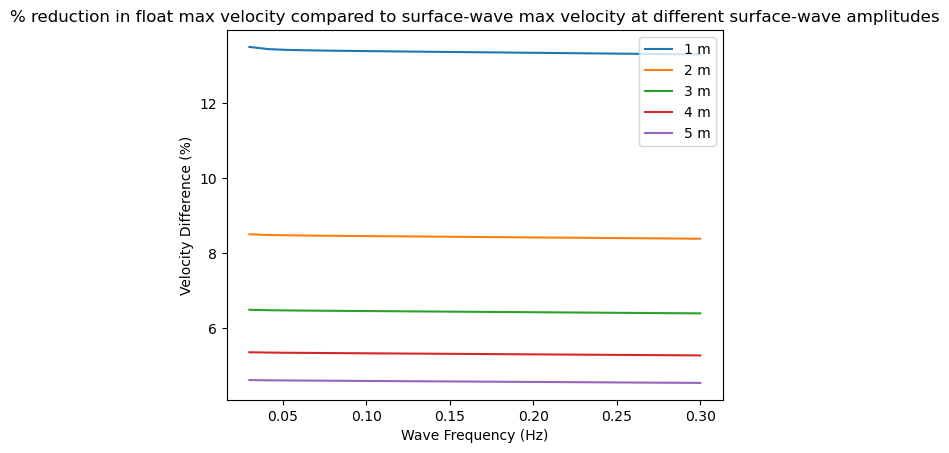

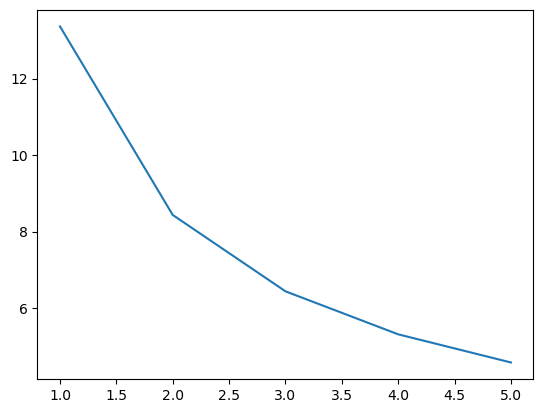

In [32]:
plt.figure()
mean_diff = []
for a_i in range(len(a_ar)):
    plt.plot(f, diff_mat[a_i, :], label=str(a_ar[a_i])+" m")
    mean_diff = mean_diff + [np.nanmean(diff_mat[a_i, :])]
    

plt.legend()
plt.xlabel("Wave Frequency (Hz)")
plt.ylabel("Velocity Difference (%)")
plt.title("% reduction in float max velocity compared to surface-wave max velocity at different surface-wave amplitudes")
#plt.plot(f, diff_store)
#plt.plot(f, max_u_store)

plt.figure()
plt.plot(a_ar, mean_diff)
mean_diff = np.array(mean_diff)

Here we see that increasing frequency results in a reduction of the max velocity of the float compared to the max water velocity. However, the stronger the amplitude of the wave, the closer the float gets to the water velocity.


Note that the Drag coefficient is assumed to be 1, but variations in this would also have some impact. I believe that for a cylinder the Cd is experimentally been observed to be ~1 for a range of reynods numbers. But the impact of varying Cd is shown below. Assuming an amplitude of 1m/s the variations in the drag coefficent simply alter the magnitude of the difference between the float and current, as can be seen below:

In [59]:
#Vary Cd and see what the difference in max response is
Cd = 1
Mf = 28 #kg
A=.165*1.27 #(float area?)
f = np.linspace(0.03, 0.5, 25)
omega = 2*np.pi*f #Go w/ a 10s wave
cd_ar = np.linspace(0.5, 1.5, 10)
#a_ar = np.append(a_ar)
rho = 1000
diff_mat = np.zeros((len(cd_ar), len(omega)))
a=1
for cd_ind in range(len(cd_ar)):
    cd = cd_ar[cd_ind]
    diff_store = []
    max_u_store = []
    for o in omega:
        tarr = np.linspace(0, 25, 5000)
        u = a * np.cos(o*tarr)
        u_float_saver, a_arr=get_u_float(u, tarr, Cd=cd)
        delta=u[2000:]-u_float_saver[2000:]
        ind = np.where(np.abs(delta)<0.01)[0][0]
        max_diff = np.max(u)-np.abs(u_float_saver[2000+ind])
        max_u_store = max_u_store + [np.max(u)]
        diff_store = diff_store + [max_diff/a]
    diff_mat[cd_ind, :] = diff_store

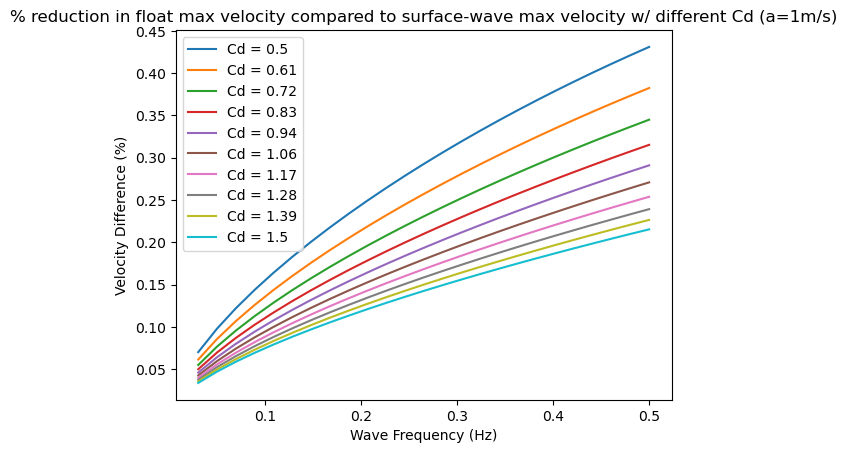

In [60]:
plt.figure()
for c_i in range(len(cd_ar)):
    plt.plot(f, diff_mat[c_i, :], label="Cd = " + str(round(cd_ar[c_i], 2)))

plt.legend()
plt.xlabel("Wave Frequency (Hz)");
plt.ylabel("Velocity Difference (%)");
plt.title("% reduction in float max velocity compared to surface-wave max velocity w/ different Cd (a=1m/s)");


Finally, the phase offset between the float velocities and the water velocities as a function of frequency are shown below. Increasing frequency results in a increased phase offset (where if $u_w \propto \sin(\omega t)$, and $u_f\propto\sin(\omega t + \phi_0)$, then $\phi_0$ is the phase offset shown here. Note that $\phi_0 = \omega \tau_0$ where $\tau_0$ is the time offset between the water and float velocities.

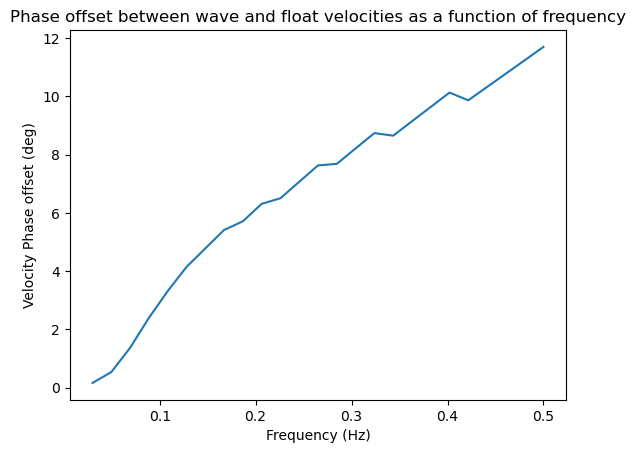

In [64]:
plt.plot(f, np.array(tdiff_store)*180/np.pi)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Velocity Phase offset (deg)");
plt.title("Phase offset between wave and float velocities as a function of frequency");

In [53]:
c_ar = np.linspace(-0.5, -0.3, 5)
factored_diff_ar = np.zeros((len(c_ar), len(mean_diff)))
for c_ind in range(len(c_ar)):
    factored_diff_ar[c_ind, :] = mean_diff*(1+c_ar[c_ind])/(1+0.5)


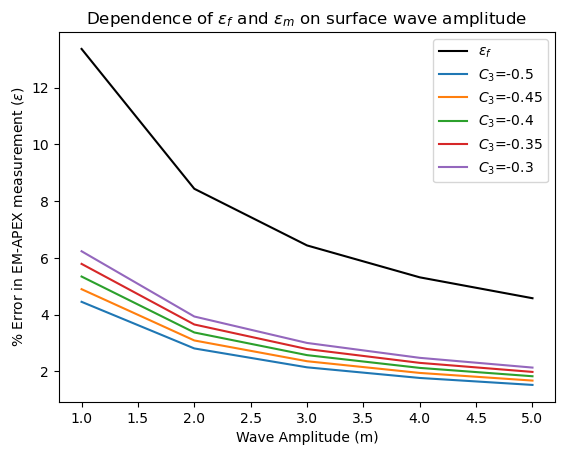

In [64]:
plt.plot(a_ar, mean_diff, color='k', label=r"$\epsilon_f$")
for c_ind in range(len(c_ar)):
    plt.plot(a_ar, factored_diff_ar[c_ind, :], label=r"$C_{3}$="+str(c_ar[c_ind]))
plt.legend()
plt.ylabel("% Error in EM-APEX measurement ($\epsilon$)")
plt.xlabel("Wave Amplitude (m)")
plt.title(r"Dependence of $\epsilon_f$ and $\epsilon_m$ on surface wave amplitude")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/drag_model.png")

In [ ]:
#Convert to actual %